<a href="https://colab.research.google.com/github/ritaxtii/imageProcessing/blob/main/ResNet50_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [344]:
!pip install tensorflow==2.14.0

In [345]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/FinalProjectImage2/TrafficSignsDataset.zip'
extract_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [346]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


from keras.applications import *
from keras.applications.vgg19 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [347]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D,GlobalAveragePooling2D

In [348]:
model_ResNet50=ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
#model_xception=Xception(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

In [349]:
f1=Flatten()(model_ResNet50.output)
final_layer = Dense(17,activation='Softmax')(f1)
model_ResNet50=Model(inputs=model_ResNet50.input,outputs = final_layer)
model_ResNet50.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [350]:
for i,layer in enumerate(model_ResNet50.layers):
  print(i,layer.name)

0 input_8
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [351]:
#Create DataGeneartor Object
datagen = ImageDataGenerator(zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             rescale=1/255,
                             fill_mode="nearest")

In [352]:
train_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Train'
validate_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Validate'
test_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Test'

In [353]:
# Create Train Image generator
train_generator = datagen.flow_from_directory(directory=train_path,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=16,
                                              class_mode='categorical',
                                              seed=42,
                                              shuffle=True)

Found 1625 images belonging to 17 classes.


In [354]:
# Create Validation Image generator
val_generator = datagen.flow_from_directory(directory=validate_path,
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            batch_size=4,
                                            class_mode='categorical',
                                            seed=42,
                                            shuffle=True)

Found 406 images belonging to 17 classes.


In [355]:
# สร้างฟังก์ชันสำหรับแสดงรูปภาพเป็นตาราง 4x4
def plot_images(generator, num_images=16):
    # สร้าง subplot 4x4
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    # ดึงรูปภาพจาก generator
    for i in range(num_images):
        # ดึงรูปภาพ
        batch = generator.next()
        img = batch[0][0]

        # แสดงรูปภาพ
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

In [356]:
# Create Optimizer
opts = Adam(learning_rate = 0.0001, use_ema=True)
model_ResNet50.compile(loss='categorical_crossentropy',optimizer=opts,metrics=['accuracy'])

In [357]:
# Define training Generator Parameter
EP = 20
step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not, adjust batch_size to make it equal
if step_size_train == step_size_val:
    print("step_size_train is equal to step_size_val.")
    print(f"Number of steps per epoch: {step_size_train}")
else:
    print("step_size_train is not equal to step_size_val.")
    print(f"Number of steps per epoch (train): {step_size_train}")
    print(f"Number of steps per epoch (validation): {step_size_val}")

step_size_train is equal to step_size_val.
Number of steps per epoch: 101


In [358]:
print(type(train_generator))
print(type(val_generator))
print(train_generator.image_shape)
print(val_generator.image_shape)

<class 'keras.src.preprocessing.image.DirectoryIterator'>
<class 'keras.src.preprocessing.image.DirectoryIterator'>
(224, 224, 3)
(224, 224, 3)


In [359]:
history = model_ResNet50.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=val_generator,
    validation_steps=step_size_val,
    epochs=EP,
    verbose=1
)


Epoch 1/20
101/101 [==============================] - 112s 468ms/step - loss: 0.7350 - accuracy: 0.8347 - val_loss: 4.3280 - val_accuracy: 0.1089
Epoch 2/20
101/101 [==============================] - 43s 419ms/step - loss: 0.0580 - accuracy: 0.9869 - val_loss: 12.5288 - val_accuracy: 0.0545
Epoch 3/20
101/101 [==============================] - 41s 404ms/step - loss: 0.0319 - accuracy: 0.9938 - val_loss: 9.5112 - val_accuracy: 0.0446
Epoch 4/20
101/101 [==============================] - 40s 400ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 6.8426 - val_accuracy: 0.0842
Epoch 5/20
101/101 [==============================] - 39s 380ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 5.6758 - val_accuracy: 0.1584
Epoch 6/20
101/101 [==============================] - 40s 394ms/step - loss: 0.0449 - accuracy: 0.9919 - val_loss: 1.7880 - val_accuracy: 0.6163
Epoch 7/20
101/101 [==============================] - 39s 388ms/step - loss: 0.0614 - accuracy: 0.9832 - val_loss: 1.2935 - val_

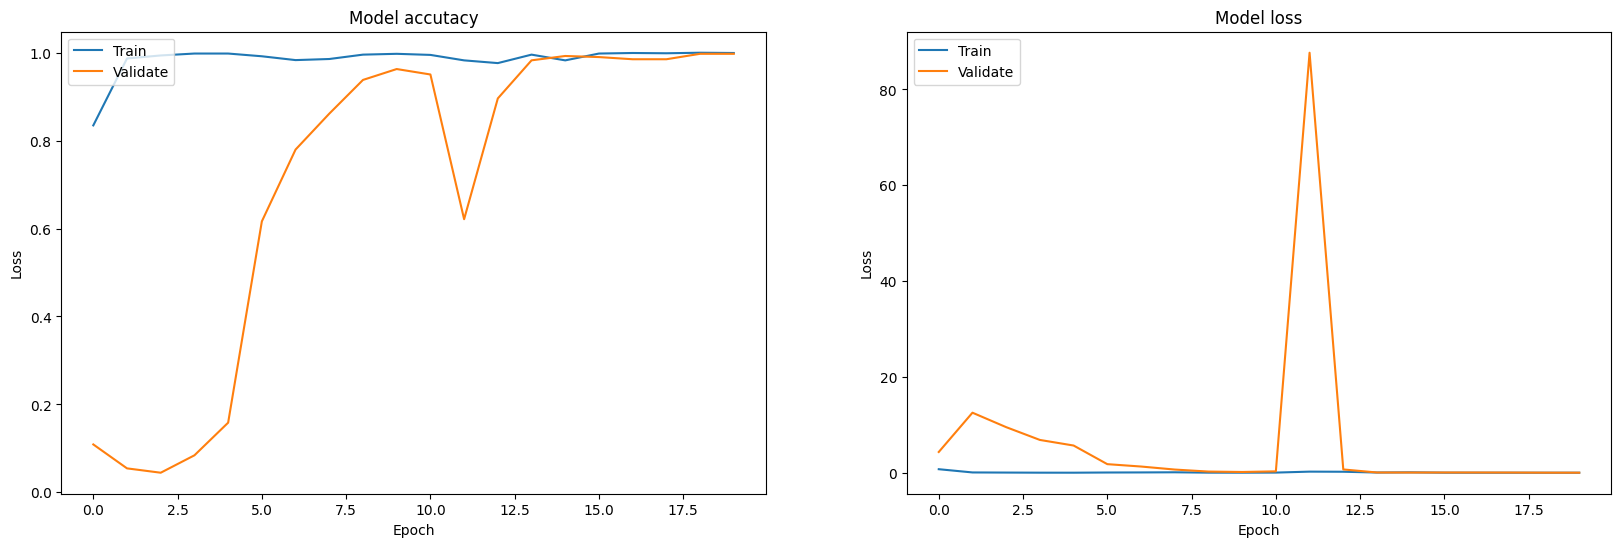

In [360]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")
plt.title('Model accutacy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')

# View Loss (Training, Validation)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')

In [361]:
# Initial test generator
Test_generator = datagen.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=(224, 224), color_mode="rgb",
    shuffle=False,
    batch_size=1)

Found 893 images belonging to 17 classes.


In [362]:
#Get class id for y_real_class
y_true = Test_generator.classes

In [363]:
print(Test_generator.class_indices)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16}


In [364]:
#predict images according to test_generator # number of real class
preds = model_ResNet50.predict_generator(Test_generator)
print(preds.shape)
print(preds)

<ipython-input-364-a7f1ffe748c4>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model_ResNet50.predict_generator(Test_generator)


(893, 17)
[[1.0000000e+00 3.5219073e-15 5.6964529e-18 ... 1.8171285e-19
  6.8520222e-18 4.5092815e-15]
 [1.0000000e+00 3.3397476e-21 2.6949155e-16 ... 3.2142814e-20
  1.8089783e-22 1.4851360e-18]
 [1.0000000e+00 3.5894047e-19 3.8505462e-19 ... 2.1068987e-21
  1.7515180e-21 3.2003246e-18]
 ...
 [9.2158061e-31 6.1678821e-29 2.7066631e-29 ... 6.3852515e-33
  7.1718672e-36 1.0000000e+00]
 [9.0428282e-32 8.2889902e-32 2.9701814e-30 ... 3.5403738e-38
  0.0000000e+00 1.0000000e+00]
 [1.0320197e-21 1.2905230e-21 1.9937599e-21 ... 9.3109492e-20
  2.6906478e-27 1.0000000e+00]]


In [365]:
y_pred = np.argmax(preds,axis=1)
print(Test_generator.classes)
print(y_pred)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6

In [366]:
#Calculate confusion matrix, classification report between y_true and df_class

#print(confusion_matrix(y_true, y_pred))
# Calculate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Get the number of classes
num_classes = confusion.shape[0]

# Create a formatted confusion matrix with class labels
formatted_confusion = np.zeros((num_classes, num_classes), dtype=int)

for i in range(num_classes):
    for j in range(num_classes):
        formatted_confusion[i, j] = confusion[i, j]

# Print the formatted confusion matrix
print("Confusion Matrix:")
for i in range(num_classes):
    row = "Class " + str(i) + " | "
    for j in range(num_classes):
        row += str(formatted_confusion[i, j]) + " "
    print(row)
print(classification_report(y_true, y_pred))

Confusion Matrix:
Class 0 | 35 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 1 | 0 78 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 2 | 0 0 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 3 | 0 0 0 58 0 0 0 0 0 0 0 0 0 0 0 0 0 
Class 4 | 0 0 0 0 45 0 0 0 0 0 0 0 0 0 0 0 0 
Class 5 | 0 0 0 1 0 64 0 0 0 0 0 0 0 0 0 0 0 
Class 6 | 0 0 0 0 0 0 28 0 0 0 0 0 0 0 0 0 0 
Class 7 | 0 0 0 0 0 0 0 38 0 0 0 0 0 0 0 0 0 
Class 8 | 0 0 0 0 0 0 0 0 42 0 0 0 0 0 0 0 0 
Class 9 | 0 0 0 0 0 0 0 0 0 39 0 0 0 0 0 0 0 
Class 10 | 0 0 0 0 0 0 0 0 0 0 30 0 0 0 0 0 0 
Class 11 | 0 0 0 0 0 0 0 0 0 0 0 37 0 0 0 0 0 
Class 12 | 0 0 0 0 0 0 0 0 0 0 0 0 133 0 0 0 0 
Class 13 | 0 0 0 0 0 0 0 0 0 0 0 0 0 45 0 0 0 
Class 14 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 46 0 0 
Class 15 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 97 0 
Class 16 | 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 48 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        78
           2       1.00      

In [367]:
invert_Test_class =  {v: k for k, v in Test_generator.class_indices.items()}
print(invert_Test_class)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q'}


1/1 [==============================] - 0s 39ms/step
[[1.2060291e-13 2.1143540e-14 8.6149469e-13 1.1019989e-08 5.8555324e-16
  6.0284546e-13 1.4950659e-11 1.7723101e-13 6.0716031e-16 3.6730684e-11
  4.6315863e-12 1.4778655e-14 4.2885677e-13 1.0000000e+00 3.7741247e-12
  2.7923388e-09 2.2714706e-14]]
Predicted class: [13]
True class: n


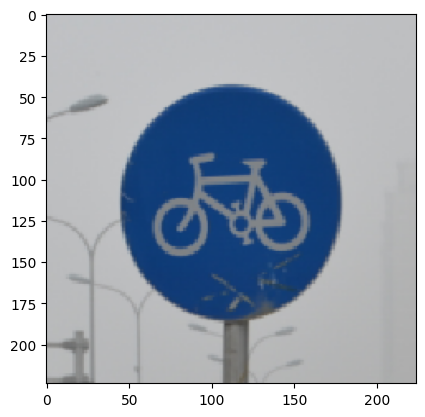

In [373]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
image_path = '/content/drive/MyDrive/FinalProjectImage2/Dataset/Test/n/030_1_0014.png'  # Replace with the path to your image
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = preprocess_input(img)  # Apply preprocessing function

# Make a prediction
predictions = model_ResNet50.predict(img)
print(predictions)

# Get the class with the highest probability (argmax)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
print("Predicted class:", predicted_class)
print("True class:",invert_Test_class[int(predicted_class)])

In [371]:
from tensorflow.keras.models import load_model

# Save the model to an HDF5 file
model_ResNet50.save('/content/drive/MyDrive/FinalProjectImage2/model_model_ResNet50_20epoch.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
